In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import time
import urllib
import os
from tqdm import tqdm
import math
import requests
from astropy.time import Time
from scipy.optimize import curve_fit
import plotly.express as px
from bs4 import BeautifulSoup
import requests, lxml, re, json
import pickle
from umap import UMAP
from astropy.io import fits
import plotly.express as px

In [ ]:
def get_acs_lc(grb_time,duration):
    '''
    Returns light curve for specific time
    Time is in example format 2002-02-02T03:03:03
    duration = int 
    '''
    content=urllib.request.urlopen('https://www.isdc.unige.ch/~savchenk/spiacs-online/spiacs.pl?requeststring='+grb_time[0:13]+'%3A'+grb_time[14:16]+'%3A'+grb_time[17:]+'+'+str(duration)+'&generate=ipnlc&submit=Submit')
    content=list(content)
    content.pop(0)
    content.pop(0)
    seconds=[]
    counts=[]
    if (content[0].split()[0]!=b'your'):
        for line in content:
            x=line.split()
            if len(x)==1:
                break
            else:
                secs,count=x[0],x[1]
                seconds.append(float(secs))
                counts.append(float(count))
    else:
        time.sleep(60)
        content=urllib.request.urlopen('https://www.isdc.unige.ch/~savchenk/spiacs-online/spiacs.pl?requeststring='+grb_time[0:13]+'%3A'+grb_time[14:16]+'%3A'+grb_time[17:]+'+'+str(duration)+'&generate=ipnlc&submit=Submit')
        content=list(content)
        content.pop(0)
        content.pop(0)
        for line in content:
            x=line.split()
            if len(x)==1:
                break
            else:
                secs,count=x[0],x[1]
                seconds.append(float(secs))
                counts.append(float(count))
    return np.vstack((seconds,counts)).T

In [4]:
np.full(8, 7)

array([7, 7, 7, 7, 7, 7, 7, 7])

In [5]:
final = pd.read_excel('candidates_crossmatched_final (2).xlsx')
final['datetime_start'] = (final['datetime']-pd.to_timedelta(2*final['duration'], unit='s')).dt.strftime('%Y-%m-%dT%H:%M:%S')
final['datetime_finish'] = (final['datetime']+pd.to_timedelta(3*final['duration'], unit='s')).dt.strftime('%Y-%m-%dT%H:%M:%S')
final['dT'] = (final['duration_err']/10).astype(int)
df = pd.read_csv('candidates_detector_data.csv',parse_dates=['datetime']).set_index('datetime').merge(final.set_index('datetime'),left_index=True,right_index=True)[['acs_flux','duration','distance_x','iremtc3.da_flux','ibis_veto__flux','isgri_E20-_flux','jmx1_E3-20_flux','jmx2_E3-20_flux','picsit_evt_flux','picsit_spe_flux','spi_E20-50_flux','Bkg', 'Hurley','RHESSI', 'Konus', 'GOES', 'Candidate']]
df_cand = pd.read_csv('candidates_bins_data.csv',parse_dates=['datetime']).set_index('datetime')
df_cand = df_cand.apply(lambda x:(x-np.min(x))/np.sum(x-np.min(x)),axis=1)
df = df.merge(df_cand,left_index=True,right_index=True)
df = df[df!=np.inf].dropna()
df

,acs_flux,duration,distance_x,iremtc3.da_flux,ibis_veto__flux,isgri_E20-_flux,jmx1_E3-20_flux,jmx2_E3-20_flux,picsit_evt_flux,picsit_spe_flux,...,0_bin,1_bin,2_bin,3_bin,4_bin,5_bin,6_bin,7_bin,8_bin,9_bin
datetime,,,,,,,,,,,,,,,,,,,,,
2003-02-14 09:49:43.816,99709.228577,380,158453.991691,147642.781250,4.597248,241.587233,52.299291,70.301765,0.0,441.681107,...,0.016960,0.051848,0.092503,0.124724,0.156978,0.175520,0.162030,0.131420,0.088017,0.0
2003-02-15 11:12:13.993,48849.252930,399,114211.591765,0.000000,-0.506576,-1.891384,-0.394558,-0.355817,0.0,49.849897,...,0.016107,0.050850,0.091839,0.125304,0.157111,0.175038,0.156872,0.134901,0.091978,0.0
2003-02-15 11:13:44.816,87139.530457,260,112863.210584,-29143.187500,-1.163334,909.150373,83.790173,114.181686,0.0,164.760406,...,0.018568,0.053106,0.085824,0.124179,0.149521,0.165060,0.166103,0.145546,0.092094,0.0
2003-02-15 11:14:03.816,80037.297424,180,112873.337338,-14568.156250,-1.051227,2480.009488,232.289831,318.553010,0.0,316.403992,...,0.021596,0.051352,0.088486,0.122291,0.151155,0.173751,0.164228,0.139799,0.087343,0.0
2003-02-17 02:42:43.816,124275.544189,260,150300.495887,185770.187500,-7.991562,132.308917,95.925394,95.577247,0.0,26.920962,...,0.018568,0.053106,0.085824,0.124179,0.149521,0.165060,0.166103,0.145546,0.092094,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22 00:44:38.816,786535.042480,500,119037.231057,13088.992188,28615.829285,-0.398237,214.645284,416.682898,0.0,308.456360,...,0.023482,0.056102,0.090128,0.125259,0.152736,0.150233,0.166065,0.147864,0.088131,0.0
2021-10-23 13:02:39.816,355513.531250,380,144457.241113,71657.815430,5428.494629,0.000000,0.000000,0.000000,0.0,0.000000,...,0.016960,0.051848,0.092503,0.124724,0.156978,0.175520,0.162030,0.131420,0.088017,0.0
2021-10-23 13:04:14.816,341770.945312,340,144448.395876,71657.815430,5410.608887,0.000000,0.000000,0.000000,0.0,0.000000,...,0.018445,0.052969,0.092430,0.126151,0.154162,0.174778,0.171740,0.132046,0.077277,0.0


In [6]:
df['GRB'] = df['Hurley']|df['Konus']
df['SOLAR'] = df['RHESSI']|df['GOES']

In [7]:
transformed = UMAP(n_neighbors=30).fit_transform(df)

In [8]:
df['umaped_1'] = transformed[:,0]
df['umaped_2'] = transformed[:,1]

In [9]:
fig = px.scatter(x=transformed[[True if ((row['GRB']==1) or (row['Bkg']==1)) else False for i,row in df.iterrows()],0],
                 y=transformed[[True if ((row['GRB']==1) or (row['Bkg']==1)) else False for i,row in df.iterrows()],1],
                 color = [0 if row['GRB']==1 else 2 if row['Bkg']==1 else 1 for i,row in df.iterrows() if ((row['GRB']==1) or (row['Bkg']==1))])
fig.show()

In [10]:
data = None
for idx,detector in enumerate(['Bkg','GRB','SOLAR']):
    tmp = df[df[detector]==1][['acs_flux', 'duration', 'distance_x', 'iremtc3.da_flux',
       'ibis_veto__flux', 'isgri_E20-_flux', 'jmx1_E3-20_flux',
       'jmx2_E3-20_flux', 'picsit_evt_flux', 'picsit_spe_flux',
       'spi_E20-50_flux','0_bin', '1_bin', '2_bin', '3_bin', '4_bin', '5_bin',
       '6_bin', '7_bin', '8_bin', '9_bin','umaped_1','umaped_2']]
    tmp['label'] = idx
    data = pd.concat((data,tmp))

In [5]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score,balanced_accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV

In [12]:
X = data.drop(columns=['label'])
Y = data['label']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

In [13]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,Y_train,verbose=1)
print(fbeta_score(Y_test,lgbm.predict(X_test),beta=2,average='weighted'),
      balanced_accuracy_score(Y_test,lgbm.predict(X_test)),
      roc_auc_score(Y_test,lgbm.predict_proba(X_test),multi_class='ovr'))

c:\Users\georg\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



0.618883612377615 0.5538220854667997 0.7730194708536451


In [6]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
y_score = lgbm.predict_proba(X_test)
fig, ax = plt.subplots(figsize=(6, 6))

fig = plt.Figure()
for class_id,classs in enumerate(['Bkg','GRB','SOLAR']):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {classs}",
        ax = ax
    )
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for random prediction (AUC = 0.5)")
plt.show()

NameError: name 'Y_train' is not defined

Уберём SOLAR т.к. точность ужасная

In [15]:
data_pruned = None
for idx,detector in enumerate(['Bkg','GRB']):
    tmp = df[df[detector]==1][['acs_flux', 'duration', 'distance_x', 'iremtc3.da_flux',
       'ibis_veto__flux', 'isgri_E20-_flux', 'jmx1_E3-20_flux',
       'jmx2_E3-20_flux', 'picsit_evt_flux', 'picsit_spe_flux',
       'spi_E20-50_flux','0_bin', '1_bin', '2_bin', '3_bin', '4_bin', '5_bin',
       '6_bin', '7_bin', '8_bin', '9_bin','umaped_1','umaped_2']]
    tmp['label'] = idx
    data_pruned = pd.concat((data_pruned,tmp))

In [16]:
X_pruned = data_pruned.drop(columns=['label'])
Y_pruned = data_pruned['label']
X_train_2,X_test_2,Y_train_2,Y_test_2 = train_test_split(X_pruned,Y_pruned)

lgbm_2 = LGBMClassifier()
lgbm_2.fit(X_train_2,Y_train_2,verbose=1)

print(fbeta_score(Y_test_2,lgbm_2.predict(X_test_2),beta=2,average='weighted'),
      balanced_accuracy_score(Y_test_2,lgbm_2.predict(X_test_2)),
      roc_auc_score(Y_test_2,lgbm_2.predict(X_test_2)))

0.8648410681178113 0.8649964607139246 0.8649964607139247


c:\Users\georg\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



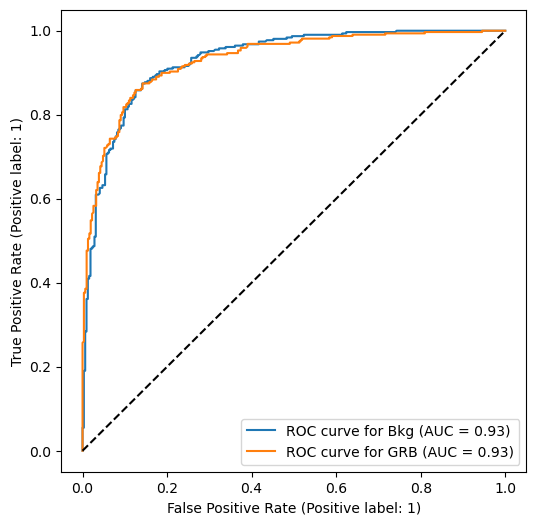

In [18]:
label_binarizer_2 = LabelBinarizer().fit(Y_train_2)
y_onehot_test_2 = label_binarizer.transform(Y_test_2)
y_score_2 = lgbm_2.predict_proba(X_test_2)
fig, ax = plt.subplots(figsize=(6, 6))

fig = plt.Figure()
for class_id,classs in enumerate(['Bkg','GRB']):
    RocCurveDisplay.from_predictions(
        y_onehot_test_2[:, class_id],
        y_score_2[:, class_id],
        name=f"ROC curve for {classs}",
        ax = ax
    )
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for random prediction (AUC = 0.5)")
plt.show()

Рассмотрим отдельно кандидаты

In [22]:
df_candidates = df[df['Candidate']==1][lgbm_2.feature_name_]
df_candidates['proba_grb'] = lgbm_2.predict_proba(df_candidates)[:,1]

Text(0.5, 0, 'distance, km')

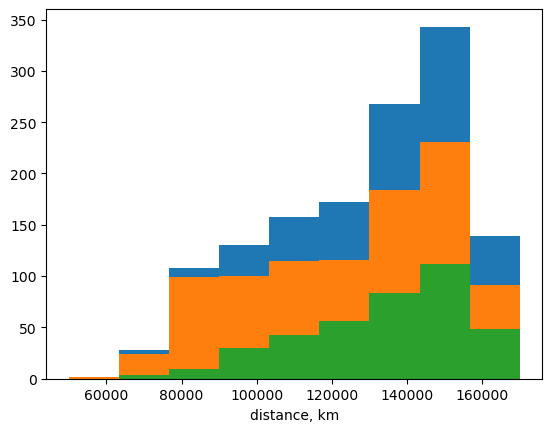

In [91]:
bins_all,a,b = plt.hist(df_candidates['distance_x'],bins=np.linspace(50000,170000,10))
bins_bkg,_,_ = plt.hist(df_candidates[df_candidates['proba_grb']<0.5]['distance_x'],bins=np.linspace(50000,170000,10))
bins_grb,_,_ = plt.hist(df_candidates[df_candidates['proba_grb']>0.5]['distance_x'],bins=np.linspace(50000,170000,10))
plt.xlabel('distance, km')

Text(0.5, 0, 'distance, km')

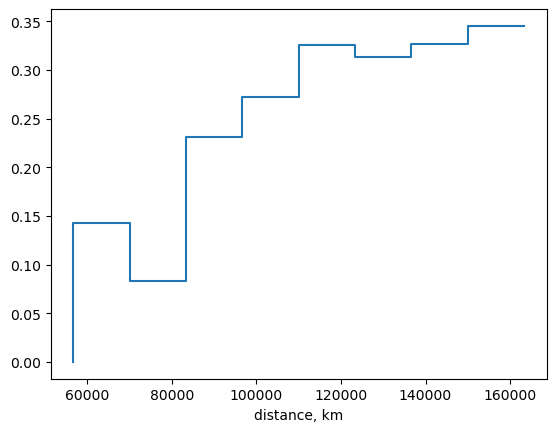

In [92]:
plt.step((a[1:]+a[:-1])/2,bins_grb/bins_all)
plt.xlabel('distance, km')

In [48]:
bins_grb/bins_all

array([0.        , 0.14285714, 0.08333333, 0.23076923, 0.2721519 ,
       0.3255814 , 0.31343284, 0.32653061, 0.34532374])

<AxesSubplot:xlabel='name'>

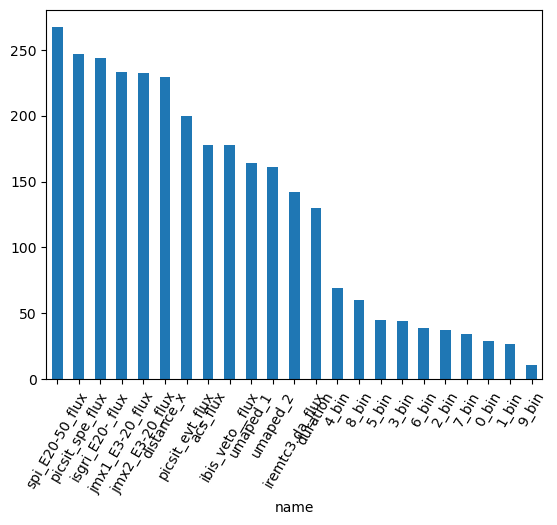

In [38]:
feature_imps = pd.DataFrame(list(zip(lgbm_2.feature_name_,lgbm_2.feature_importances_)),columns=['name','importance']).set_index('name').sort_values('importance',ascending=False)
feature_imps['importance'].plot(kind='bar',rot=60)


In [102]:
with open('model_bkg-grb_lgbm.pkl','wb') as f:
    pickle.dump(lgbm_2,f)

In [32]:
df_candidates.sort_values('proba_grb',ascending=False).head(5)

,acs_flux,duration,distance_x,iremtc3.da_flux,ibis_veto__flux,isgri_E20-_flux,jmx1_E3-20_flux,jmx2_E3-20_flux,picsit_evt_flux,picsit_spe_flux,...,3_bin,4_bin,5_bin,6_bin,7_bin,8_bin,9_bin,umaped_1,umaped_2,proba_grb
datetime,,,,,,,,,,,,,,,,,,,,,
2012-02-09 01:34:42.816,69194.109863,159,159620.452046,0.000000,132.182596,-12.959245,0.974687,-2.032345,2.848637,-174.721008,...,0.120209,0.152005,0.170474,0.172328,0.139074,0.086258,0.0,12.215276,5.581679,0.999257
2014-02-07 10:12:41.816,51359.980469,200,161630.433264,0.000000,13748.181152,763.182281,-32.131243,15.348358,3.631271,602.822510,...,0.122481,0.154458,0.168951,0.164542,0.140393,0.087556,0.0,12.726770,4.556560,0.997667
2011-10-15 07:56:04.816,30505.972412,160,162388.717689,-20387.000000,-1.113487,-51.800309,5.126428,-13.358410,1.517628,-315.118164,...,0.121157,0.151448,0.170465,0.171316,0.138509,0.086653,0.0,13.187797,3.304161,0.997209
2015-06-02 20:10:36.816,45002.792480,160,145251.722444,0.000000,106.707053,119.192870,19.593444,9.242370,0.000000,99.825684,...,0.121157,0.151448,0.170465,0.171316,0.138509,0.086653,0.0,12.997866,4.680995,0.995454
2013-07-14 05:20:40.816,231949.109375,380,102230.776853,261897.507812,9430.816162,226.912200,4.947717,10.865303,8.097824,158.044312,...,0.124724,0.156978,0.175520,0.162030,0.131420,0.088017,0.0,5.556072,7.745983,0.994884


In [70]:
acs_data.get_ijd_from_utc(str(event_datetime)[:19])

'2012-02-09 01:34:42'

In [99]:
event_datetime = df_candidates.sort_values('proba_grb').reset_index().iloc[3]['datetime']
event_datetime

Timestamp('2017-01-07 14:41:48.816000')

In [100]:
get_pic(event_datetime)

c:\Users\georg\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning:

Unverified HTTPS request is being made to host '193.232.11.95'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings



In [71]:
def get_pic(event_datetime):
    row = final.set_index('datetime').loc[event_datetime]
    r = requests.get(f"https://193.232.11.95/lvc/r/Mozgunov/20220928/Candidates/{acs_data.get_ijd_from_utc(str(row['datetime_start'])[:19])}_{acs_data.get_ijd_from_utc(str(row['datetime_finish'])[:19])}__{row['dT']}s/8det.png",verify=False,stream=True)
    with open(f"pics_bkg/{event_datetime}_pic.png", 'wb') as f:
        f.write(r.raw.read())

In [61]:
(lgbm.predict(df[df['Candidate']==1][lgbm.feature_name_])==0).sum()

708

In [56]:
predictions_candidates[predictions_candidates[:,2]>0.9]

array([[0.00364042, 0.08900256, 0.90735702],
       [0.01871828, 0.05195089, 0.92933082],
       [0.04085465, 0.02347452, 0.93567083],
       [0.00833634, 0.06373425, 0.92792941],
       [0.04929869, 0.04314302, 0.90755829],
       [0.03870083, 0.00659941, 0.95469976],
       [0.00618166, 0.04483737, 0.94898097],
       [0.01600175, 0.04967058, 0.93432767],
       [0.02158211, 0.02713736, 0.95128053],
       [0.01417922, 0.049656  , 0.93616478],
       [0.0163482 , 0.01830734, 0.96534447],
       [0.00195011, 0.02858114, 0.96946875],
       [0.01326571, 0.07728263, 0.90945166],
       [0.0428291 , 0.04168958, 0.91548132],
       [0.00646022, 0.05222494, 0.94131484],
       [0.00439527, 0.09426844, 0.9013363 ],
       [0.01467672, 0.03101711, 0.95430617],
       [0.02015284, 0.0114504 , 0.96839676],
       [0.00736121, 0.05023329, 0.9424055 ],
       [0.00940961, 0.06049385, 0.93009653],
       [0.00407899, 0.05496317, 0.94095785],
       [0.03135875, 0.02647403, 0.94216722],
       [0.

In [14]:
config.ROOT_DIR

'c:\\Python projects\\GRB_data_processing'

In [106]:
def process_file(filename,left=None,right=None):
    try:
        x,x_err,y,y_err = np.hsplit(np.loadtxt(f"pics_bkg/{filename}"),4)
        x = x.reshape(-1,)
        x_err = x_err.reshape(-1,)
        y = y.reshape(-1,)
        y_err = y_err.reshape(-1,)

        x_ev,y_ev,mod_3=p=find_event(x,y)
        if left is None:
            left = np.min(x_ev)
            right = np.max(x_ev)
        else:
            x_ev = x[(x>left)&(x<right)]
            y_ev = y[(x>left)&(x<right)]
        chi=Chi2(x[(x<=left)|(x>=right)],y[(x<=left)|(x>=right)],y_err[(x<=left)|(x>=right)],mod_3)
        
        return y_ev,x_ev,mod_3,chi,left,right
    except TypeError:
        return [],[],[],0,left,right
    except ValueError:
        return [],[],[],0,left,right

In [110]:
import warnings
import os.path

warnings.filterwarnings("ignore")
# result = {}
try:
    for idx,folder in enumerate(['Candidates_badorbit','Candidates','Crossmatched_badorbit']): #'Crossmatched',
        r = requests.get(f"https://193.232.11.95/lvc/r/Mozgunov/20220928/{folder}/",verify=False)
        soup = BeautifulSoup(r.text)
        for link in tqdm(soup.find_all('a')[5:-2]):
            r = requests.get(f"https://193.232.11.95/lvc/r/Mozgunov/20220928/{folder}/{link['href']}",verify=False)
            soup = BeautifulSoup(r.text)
            start_time = list(acs_data.get_utc_from_ijd(link['href'].split('_')[0])[:19])
            start_time[10]= 'T'
            start_time = ''.join(start_time)
            t0 = final[final['datetime_start']==start_time]['datetime'].values[0]
            if t0 not in result:
                acs_lc = get_acs_lc(pd.to_datetime(str(t0)).strftime("%Y-%m-%d %H:%M:%S"),int(final[final['datetime_start']==start_time]['duration'].values[0]),'ijd')
                left = float(acs_data.get_ijd_from_utc(str(final[final['datetime']==time]['datetime'].values[0])))
                right = float(acs_data.get_ijd_from_utc(str(final[final['datetime']==time]['datetime'].values[0]))) + final[final['datetime_start']==start_time]['duration'].values[0]/(24*60*60)
                result[t0] = {}
                logging.info(f'{t0=},{left=},{right=}')
                try:
                    for detector in sorted([x['href'] for x in soup.find_all('a')[5:] if x['href'] not in ['info.dat','obts.dat','obts.dat.obt2ijd','scws/','8det.png']]):
                        r = requests.get(f"https://193.232.11.95/lvc/r/Mozgunov/20220928/{folder}/{link['href']}/{detector}",verify=False,stream=True)
                        with open(f"pics_bkg/{detector}", 'wb') as f:
                            f.write(r.raw.read())
                        if detector == 'distances.dat':
                            y,x,_,_,_,_ = process_file(detector,left=left,right=right)
                            if y != []:
                                result[t0]['distance'] = np.mean(y[(x>left)&(x<right)])
                            else:
                                result[t0]['distance'] = None
                        else:
                            y,x,par,chi2,left,right = process_file(detector,left=left,right=right)
                            if detector[:3] == 'acs':
                                name = 'acs'
                            else:
                                name = detector[:10]

                            if y == []:
                                result[t0][name+'_flux'] = 0
                                result[t0][name+'_chi2'] = None
                            else:
                                result[t0][name+'_flux'] = np.sum(y-np.polyval(par,x))
                                result[t0][name+'_chi2'] = chi2

                            if detector[:3] == 'acs':
                                duration = ((right - left)/2)*24*60*60
                                lc_acs=ACS_Light_Curve(acs_data.get_utc_from_ijd((left+right)/2)[:19],duration*2)
                                lc_acs.rebin(duration/5)
                                _,_,p = find_event(lc_acs.times,lc_acs.signal)
                                signal = (lc_acs.signal - np.polyval(p,lc_acs.times))[5:15]

                                logging.info(f'{t0},{len(signal)},{signal}')
                                signal = signal + np.min(signal)
                                result[t0]['bins'] = signal/np.sum(signal)          
                except Exception:
                    logging.info(t0,'failed')
except ChunkedEncodingError:
    pass

100%|██████████| 3298/3298 [2:07:22<00:00,  2.32s/it]  


In [117]:
result

{numpy.datetime64('2003-02-14T04:04:43.816000000'): {'acs_flux': 0.0,
  'acs_chi2': 2.60986548678861,
  'bins': array([0.02428992, 0.05600265, 0.09177723, 0.12417497, 0.15305282,
         0.15496005, 0.15583803, 0.14697852, 0.09113936, 0.00178645]),
  'distance': None,
  'ibis_veto__flux': 0.0,
  'ibis_veto__chi2': 0.0003217389216183344,
  'iremtc3.da_flux': 0.0,
  'iremtc3.da_chi2': 178916319500.29578,
  'isgri_E20-_flux': 0.0,
  'isgri_E20-_chi2': 1.904064997451835,
  'jmx1_E3-20_flux': 0.0,
  'jmx1_E3-20_chi2': inf,
  'jmx2_E3-20_flux': 0.0,
  'jmx2_E3-20_chi2': inf,
  'picsit_evt_flux': 0,
  'picsit_evt_chi2': None,
  'picsit_spe_flux': 0.0,
  'picsit_spe_chi2': 13.705251077885753,
  'spi_E20-50_flux': 0,
  'spi_E20-50_chi2': None},
 numpy.datetime64('2003-02-14T09:49:43.816000000'): {'acs_flux': 0.0,
  'acs_chi2': 2.960017567809595,
  'bins': array([0.03231056, 0.06074965, 0.09388881, 0.12015382, 0.14644479,
         0.16155908, 0.15056338, 0.12561203, 0.0902319 , 0.01848598]),
  

In [120]:
[[key]+list(dict_.get('bins')) for key,dict_ in result.items()]

[[numpy.datetime64('2003-02-14T04:04:43.816000000'),
  0.02428991567197747,
  0.056002653120766785,
  0.09177723305220226,
  0.12417497423821541,
  0.153052817743088,
  0.15496004884537634,
  0.15583803177673158,
  0.14697852208244797,
  0.09113935810730293,
  0.0017864453618912646],
 [numpy.datetime64('2003-02-14T09:49:43.816000000'),
  0.032310561401332885,
  0.06074964901666285,
  0.09388881272599975,
  0.12015381886439606,
  0.14644478528351032,
  0.16155908476183375,
  0.15056337762943198,
  0.12561203107824376,
  0.0902318957508008,
  0.018485983487787853],
 [numpy.datetime64('2003-02-15T11:12:13.993000000'),
  0.03213477694325249,
  0.06023999225051547,
  0.09339799260664174,
  0.12046974051236846,
  0.14620008959287872,
  0.16070175990579674,
  0.14600701219053314,
  0.12823338964378234,
  0.09351028088577149,
  0.019104965468459415],
 [numpy.datetime64('2003-02-15T11:13:44.816000000'),
  0.02727395508410881,
  0.05811927234689373,
  0.08733964854344398,
  0.1215941460359367,
 

In [121]:
df_bins = pd.DataFrame([[key]+list(dict_.get('bins')) for key,dict_ in result.items()],
                columns = ['datetime']+[f"{i}_bin" for i in range(10)]).set_index('datetime')

In [127]:
final = pd.read_excel('candidates_crossmatched_final (2).xlsx')
final['datetime_start'] = (final['datetime']-pd.to_timedelta(2*final['duration'], unit='s')).dt.strftime('%Y-%m-%dT%H:%M:%S')
final['datetime_finish'] = (final['datetime']+pd.to_timedelta(3*final['duration'], unit='s')).dt.strftime('%Y-%m-%dT%H:%M:%S')
final['dT'] = (final['duration_err']/10).astype(int)
df = pd.read_csv('candidates_detector_data.csv',parse_dates=['datetime']).set_index('datetime').merge(final.set_index('datetime'),left_index=True,right_index=True)[['acs_flux','duration','distance_x','iremtc3.da_flux','ibis_veto__flux','isgri_E20-_flux','jmx1_E3-20_flux','jmx2_E3-20_flux','picsit_evt_flux','picsit_spe_flux','spi_E20-50_flux','Bkg', 'Hurley','RHESSI', 'Konus', 'GOES', 'Candidate']]
df = df.merge(df_bins,left_on='datetime',right_on='datetime')

In [129]:
df['GRB'] = df['Hurley']|df['Konus']
df['SOLAR'] = df['RHESSI']|df['GOES']

SystemError: initialization of _internal failed without raising an exception

In [133]:
!pip install numpy==1.23.5

In [126]:
df_bins.to_csv('candidates_bins_data.csv')

In [98]:
pd.to_datetime(str(t0)).strftime("%Y-%m-%d %H:%M:%S"),int(final[final['datetime_start']==start_time]['duration'].values[0])

('2006-09-03 07:28:54', 1400)

In [96]:
from requests.exceptions import ChunkedEncodingError

In [46]:
for i,row in final.iterrows():
    # try:
    start = row['datetime']
    finish = row['datetime'] + datetime.timedelta(seconds=row['duration']+row['duration_err'])

    central_time = str(row['datetime'] + datetime.timedelta(seconds=row['duration']/2))[:19]
    duration = ((row['duration']+row['duration_err'])/2)*60*60*24

    lc_acs=ACS_Light_Curve(central_time,duration*3)
    lc_acs.rebin(duration/5)
    _,_,p = find_event(lc_acs.times,lc_acs.signal)
    signal = (lc_acs.signal - np.polyval(p,lc_acs.times))[5:15]

    logging.info(f'{time},{len(signal)},{signal}')
    result[time]['bins'] = signal/np.sum(signal)
    # except KeyboardInterrupt:
    #     KeyboardInterrupt()
    # except BaseException as e:
    #     logging.info(time,'failed',e)

KeyboardInterrupt: 

In [ ]:
_,_,p = find_event(lc_acs.times,lc_acs.signal)
signal = lc_acs.signal - np.polyval(p,lc_acs.times)

In [ ]:
result[list(result.keys())[0]]['light_curve']['time']

[1140.1576123805,
 1140.1576355287,
 1140.1576586768,
 1140.157681825,
 1140.1577049731]

In [ ]:
times = result[list(result.keys())[0]]['light_curve']['time']

In [ ]:
central_time = acs_data.get_utc_from_ijd((times[-1]+times[0])/2)[:19]
duration = ((times[-1]-times[0])/2)*60*60*24

In [ ]:
lc_acs=ACS_Light_Curve(central_time,duration)
lc_acs.rebin(duration/5)

In [ ]:
duration/5*0.95

0.7600000600832573

In [ ]:
lc_acs.rebin(0.8)

In [ ]:
len(lc_acs.times)

10

In [ ]:
lc_acs.times

[-3.5996790196804795,
 -2.7496674876173905,
 -1.8996847818283749,
 -1.049673252076472,
 -0.1996904896633864,
 0.6503209834644461,
 1.5003325143719421,
 2.350315219005364,
 3.2003267510684537,
 3.7753210639493773]

In [ ]:
lc_acs.duration

4.00000031622767

In [ ]:
duration/10

0.400000031622767

In [ ]:
lc_acs.times

[-3.5246790070596035,
 -2.524679006091901,
 -1.5246790051241987,
 -0.5246790061210049,
 0.47532099484669743,
 1.4753209958143998,
 2.475320996782102]

In [57]:
def create_integral_curve(y):
    y_int = []
    y_temp = np.array(y)
    for i in range(len(y)):
        y_int.append(np.sum(y_temp[0:i]))
    return y_int / np.max(y_int)

def get_utc_from_ijd(ijd_time):
    url = f'https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/xTime/xTime.pl?time_in_i=&time_in_c=&time_in_d=&time_in_j=&time_in_m=&time_in_sf=&time_in_wf=&time_in_ii={ijd_time}&time_in_sl=&time_in_sni=&time_in_snu=&time_in_s=&time_in_h=&time_in_sz=&time_in_ss=&time_in_sn=&timesys_in=u&timesys_out=u&apply_clock_offset=yes'
    response = requests.get(url)
    ob = BeautifulSoup(response.text,'lxml')
    categoty = ob.find_all("td", {"id" : "time_out_i"})
    return categoty[0].string.split()[0]+' '+categoty[0].string.split()[1]

def get_ijd_from_utc(utc_time):
    utc_time = utc_time[:10]+'+'+utc_time[11:13]+'%3A'+utc_time[14:16]+'%3A'+utc_time[17:19]
    url = f'https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/xTime/xTime.pl?time_in_i={utc_time}&time_in_c=&time_in_d=&time_in_j=&time_in_m=&time_in_sf=&time_in_wf=&time_in_ii=&time_in_sl=&time_in_sni=&time_in_snu=&time_in_s=&time_in_h=&time_in_sz=&time_in_ss=&time_in_sn=&timesys_in=u&timesys_out=u&apply_clock_offset=yes'
    response = requests.get(url)
    ob = BeautifulSoup(response.text,'lxml')
    categoty = ob.find_all("td", {"id" : "time_out_ii"})
    return float(categoty[0].string.split()[0])

def get_intersect(x,y,value):
    intersect_list = list(abs(np.asarray(y) - 0.5))
    center_pos = intersect_list.index(np.min(intersect_list))
    if value > 0.5:
        for i in range(center_pos,len(x)):
            if (y[i] - value) > 0:
                return x[i]
    else:
        for i in range(center_pos,0,-1):
            if (y[i] - value) < 0:
                return x[i]

def is_between(a,x,b):
    return a <= x <= b

def align_lc(x1,y1,x2,x2_err):
    counts = []
    x1 = np.asarray(x1)
    y1 = np.asarray(y1)
    for i in range(len(x2)):
        indx = tuple([np.logical_and(x1 >= x2[i] - x2_err[i],
                                    x1 <= x2[i] + x2_err[i]
                                    )])
        counts.append(np.sum(y1[indx]))
    return np.asarray(counts)

def reverse_align(x1,x1_err,x2,x2_err,y2):
    counts = []
    mult = 60/0.05
    for i in range(len(x1)):
        temp = np.argmin(abs(x2 - x1[i]))
        counts.append(y2[temp]/mult)
    return np.asarray(counts)

def Chi2(x,y,y_err,p):
    """
    Returns Chi square functional
    x,y,y_err = same size arrays
    p = np.polyfit parameters vector
    """
    chi=0
    for i in range(0,len(x)):
        chi=chi+((y[i]-np.polyval(p,x[i]))/y_err[i])**2
    return chi/(len(x)-len(p))

def find_event(x,y):
    """
    Recieves light curve
    x,y,y_err = same size arrays
    p = np.polyfit parameters vector
    Returns bins with event
    """

    x1=np.array(x)
    y1=np.array(y)
    p=np.polyfit(x,y,3)
    y_temp=[]
    x_temp=[]
    for i in range(len(x1)):
        if is_between(-2000,x1[i],2000):
            x_temp.append(x1[i])
            y_temp.append(y1[i])

    sign_array=(np.asarray(y_temp)-np.polyval(p,np.asarray(x_temp)))/np.sqrt(np.asarray(y_temp)*1.35)
    x1=list(x1)
    y1=list(y1)
    sign_array=list(sign_array)
    peak=sign_array.index(max(sign_array))
    peak=x1.index(x_temp[peak])
    left=peak
    right=peak
    sign_array=(np.asarray(y1)-np.polyval(p,np.asarray(x1)))/np.sqrt(np.asarray(y1)*1.35)
    while sign_array[left-1]>1:
        left-=1
        if left==0:
            break
    try:
        while sign_array[right+1]>1:
            right+=1
    except:
        pass

    event=[e for e in range(left,right+1)]

    x1_fixed=[]
    y1_fixed=[]
    for i in range(0,len(x1)):
        if i not in event:
            x1_fixed.append(x1[i])
            y1_fixed.append(y1[i])
    p1=np.polyfit(x1_fixed,y1_fixed,3)

    x1=np.array(x)
    y1=np.array(y)
    y_temp=[]
    x_temp=[]
    for i in range(len(x1)):
        if is_between(-2000,x1[i],2000):
            x_temp.append(x1[i])
            y_temp.append(y1[i])

    sign_array=(np.asarray(y_temp)-np.polyval(p1,np.asarray(x_temp)))/np.sqrt(np.asarray(y_temp)*1.35)
    x1=list(x1)
    y1=list(y1)
    sign_array=list(sign_array)
    peak=sign_array.index(max(sign_array))
    peak=x1.index(x_temp[peak])
    left=peak
    right=peak
    sign_array=(np.asarray(y1)-np.polyval(p1,np.asarray(x1)))/np.sqrt(np.asarray(y1)*1.35)
    while sign_array[left-1]>1:
        left-=1
        if left==0:
            break
    try:
        while sign_array[right+1]>1:
            right+=1
    except:
        pass

    event=[e for e in range(left,right+1)]

    x1_event=[]
    y1_event=[]
    for i in range(0,len(x1)):
        if i in event:
            x1_event.append(x1[i])
            y1_event.append(y1[i])
    return x1_event,y1_event,p1

def get_acs_lc(grb_time,duration,scale='utc'):
    '''
    Returns light curve for specific time
    Time is in example format 2002-02-02T03:03:03
    duration = int
    '''
    acs = acs_data(grb_time,duration)
    return acs.get_acs_lc(scale=scale)



In [ ]:
len(lc_acs.original_times)

160

In [ ]:
lc_acs=ACS_Light_Curve(central_time,duration)
lc_acs.rebin(duration/5)

16
16
16
16
16
16
16
16
16
16


In [ ]:
lc_acs.signal

[60741.0,
 60869.0,
 60283.0,
 60967.0,
 60466.0,
 60520.0,
 61139.0,
 60980.0,
 60849.0,
 60963.0]

In [ ]:
curve = acs_data()

In [ ]:
result[np.datetime64('2003-02-14T04:04:43.816000000')]['light_curve']['time']

[1140.1576123805,
 1140.1576355287,
 1140.1576586768,
 1140.157681825,
 1140.1577049731]

In [ ]:
candidate_catalog = []
with open('E:\ACS\preliminary_candidates_1000sec.txt','r') as f:
    for line in f:
        line = line.split(',')
        t=Time(line[0],scale='utc')
        t.format = 'jd'
        t = t.value-2451544.5
        line[0] = t
        candidate_catalog.append([line[0],float(line[1])])

In [ ]:
catalog=pd.read_csv('E:/ACS/Konus-WIND catalog_fixed(1).csv')
temp_list=list(catalog['UT'])
ll2=[]
for line in temp_list:
    ll2.append(datetime.datetime.strptime(line, '%Y-%m-%d %H:%M:%S'))
catalog['UT']=ll2

In [ ]:
# N=0
# final_catalog = []
for grb in candidate_catalog[N:]:
    print(f'processing {grb[0]}')
    try:
        grb_time = get_utc_from_ijd(grb[0])[:19]
        distance = round(grb[1],2)
        lc_acs=ACS_Light_Curve(grb_time,6000)
        lc_acs.rebin(200)
        lc_acs.clear(10)
        lc=IREM_Light_curve(grb_time,6000)

        fig = plt.figure(figsize=(10,10),dpi=300)
        gs = fig.add_gridspec(17, 1)

        ax=fig.add_subplot(gs[0:14, :])
        a,b,c,d=lc_acs.get()
        ax.errorbar(a,c,xerr=b,yerr=d, fmt='o',color='black')
        ax.set_ylabel(f'ACS Counts \ {lc_acs.binning} sec')

        ax.tick_params(axis='x', labelcolor='white')

        x_ev,y_ev,mod_3=find_event(a,c)
        ax.plot(a,np.polyval(mod_3,a))
        ax.fill_between(x_ev, y_ev, np.polyval(mod_3,x_ev), step="mid", color="red", alpha=0.3)
        ax.set_xlim(-6200,6200)
        for x in x_ev:
            wrong=a.index(x)
            a.pop(wrong)
            b.pop(wrong)
            c.pop(wrong)
            d.pop(wrong)

        chi=Chi2(a,c,d,mod_3)

        grb=datetime.datetime.strptime(grb_time, '%Y-%m-%d %H:%M:%S')
        peak=grb+datetime.timedelta(0,(max(x_ev)+min(x_ev)/2))

        res = min(list(catalog['UT']), key=lambda sub: abs(sub - peak))
        index = catalog.index
        condition = catalog["UT"] == res
        grb_param  = index[condition]
        grb_param_list = catalog.iloc[grb_param].to_numpy()[0]
        left=grb+datetime.timedelta(0,min(x_ev)-100)
        right=grb+datetime.timedelta(0,max(x_ev)+100)
        print(peak,datetime.datetime.strptime(str(grb_param_list[0]), '%Y-%m-%d %H:%M:%S')+datetime.timedelta(0,grb_param_list[1]/2), is_between(left,datetime.datetime.strptime(str(grb_param_list[0]), '%Y-%m-%d %H:%M:%S')+datetime.timedelta(0,grb_param_list[1]/2),right))
        res1=datetime.datetime.strptime(str(grb_param_list[0]), '%Y-%m-%d %H:%M:%S')+datetime.timedelta(0,grb_param_list[1]/2)
        delta=res1.timestamp()-grb.timestamp()
        if is_between(left,datetime.datetime.strptime(str(grb_param_list[0]), '%Y-%m-%d %H:%M:%S')+datetime.timedelta(0,grb_param_list[1]/2),right):
            index = catalog.index
            condition = catalog["UT"] == res
            grb_param  = index[condition]
            grb_param_list = catalog.iloc[grb_param].to_numpy()[0]
            if not isinstance(grb_param_list[2],float):
                plt.title(f'{grb_time} Confirmed {grb_param_list[2]}')
            elif not isinstance(grb_param_list[3],float):
                if isinstance(grb_param_list[8],float):
                    plt.title(f'{grb_time} Type = {grb_param_list[3]}')
                else:
                    plt.title(f'{grb_time} Type = {grb_param_list[3]} Comment = {grb_param_list[8]}')
            elif not isinstance(grb_param_list[8],float):
                plt.title(f'{grb_time} Comment = {grb_param_list[8]}')
            else:
                plt.title(f'{grb_time} Type = Astr. Candidate')
        elif is_between(grb+datetime.timedelta(0,-6000),datetime.datetime.strptime(str(grb_param_list[0]), '%Y-%m-%d %H:%M:%S')+datetime.timedelta(0,grb_param_list[1]/2),grb+datetime.timedelta(0,6000)):
            ax.axvline(delta)
            if not isinstance(grb_param_list[2],float):
                plt.title(f'{grb_time} Delta {delta} Confirmed {grb_param_list[2]}')
            elif not isinstance(grb_param_list[3],float):
                if isinstance(grb_param_list[8],float):
                    plt.title(f'{grb_time} Delta {delta} Type = {grb_param_list[3]}')
                else:
                    plt.title(f'{grb_time} Delta {delta} Type = {grb_param_list[3]} Comment = {grb_param_list[8]}')
            elif not isinstance(grb_param_list[8],float):
                plt.title(f'{grb_time} Delta {delta} Comment = {grb_param_list[8]}')
            else:
                plt.title(f'{grb_time} Delta {delta} Type = Astr. Candidate')
        else:
            plt.title(f'{grb_time} Type = Astr. Candidate')

        #         plt.title(f'{grb_time} T_0-T_pericenter = {distance} Type = {grb_param_list[0,3]}')

        ax.plot([], [], ' ', label=f"Duration = {int(max(x_ev)-min(x_ev))+lc_acs.binning} +- {lc_acs.binning} sec")
        ax.plot([], [], ' ', label=f"Area = {int(np.sum(y_ev-np.polyval(mod_3,x_ev)))} +- {int(np.sqrt(np.sum(np.polyval(mod_3,x_ev))*1.35))}")
        ax.plot([], [], ' ', label=f"Sigma = {round(np.sum(y_ev-np.polyval(mod_3,x_ev))/np.sqrt(np.sum(np.polyval(mod_3,x_ev))*1.35),1)}")
        ax.plot([], [], ' ', label=f"Chi2_bkg_qubic = {round(chi,1)}")

        ax.legend(loc='upper right')


        # ax = fig.subplots(4,1)
        a,b,c,d=np.hsplit(lc.TC3,4)
        ax0=fig.add_subplot(gs[14:17, :])
        ax0.errorbar(a.reshape(-1,),c.reshape(-1,),xerr=b.reshape(-1,),yerr=d.reshape(-1,), fmt='o',color='black')
        ax0.set_ylabel('TC3 counts / 60 sec')
        ax0.axhline(np.median(c))
        ax0.set_xlabel('Time since trigger , sec')
        ax0.set_xlim(-6200,6200)

        try:
            if is_between(left,grb_param_list[0]+datetime.timedelta(0,grb_param_list[1]/2),right):
                plt.savefig(f'pics_and_list/matched/Astrophysical_and__IREM_crosmatched_# {N}')
            elif chi>4.5:
                plt.savefig(f'pics_and_list/bad_bkg/Astrophysical_and__IREM_crosmatched_# {N}')
            else:
                plt.savefig(f'pics_and_list/Astrophysical_and__IREM_crosmatched_# {N}')
        except :
            if is_between(left,grb_param_list[0]+datetime.timedelta(0,grb_param_list[1]/2),right):
                plt.savefig(f'pics_and_list/matched/Astrophysical_and__IREM_crosmatched_# {N}')
            elif chi>4.5:
                plt.savefig(f'pics_and_list/bad_bkg/Astrophysical_and__IREM_crosmatched_# {N}')
            else:
                plt.savefig(f'pics_and_list/Astrophysical_and__IREM_crosmatched_# {N}')
        plt.close(fig)
        if is_between(left,grb_param_list[0]+datetime.timedelta(0,grb_param_list[1]/2),right):
            final_catalog.append([grb+datetime.timedelta(0,min(x_ev)-100),distance,int(max(x_ev)-min(x_ev))+200,lc_acs.binning,int(sum(y_ev-np.polyval(mod_3,x_ev))),int(np.sqrt(sum(np.polyval(mod_3,x_ev))*1.35)),round(sum(y_ev-np.polyval(mod_3,x_ev))/np.sqrt(sum(np.polyval(mod_3,x_ev))*1.35),1),round(chi,1),'matched'])
        elif chi>4.5:
            final_catalog.append([grb+datetime.timedelta(0,min(x_ev)-100),distance,int(max(x_ev)-min(x_ev))+200,lc_acs.binning,int(sum(y_ev-np.polyval(mod_3,x_ev))),int(np.sqrt(sum(np.polyval(mod_3,x_ev))*1.35)),round(sum(y_ev-np.polyval(mod_3,x_ev))/np.sqrt(sum(np.polyval(mod_3,x_ev))*1.35),1),round(chi,1),'bkg'])
        else:
            final_catalog.append([grb+datetime.timedelta(0,min(x_ev)-100),distance,int(max(x_ev)-min(x_ev))+200,lc_acs.binning,int(sum(y_ev-np.polyval(mod_3,x_ev))),int(np.sqrt(sum(np.polyval(mod_3,x_ev))*1.35)),round(sum(y_ev-np.polyval(mod_3,x_ev))/np.sqrt(sum(np.polyval(mod_3,x_ev))*1.35),1),round(chi,1),'candidate'])
        N += 1
    except BaseException:
        print(f'{grb_time} failed')
        N += 1
    with open('final_catalog.pkl','wb') as f:
        pickle.dump(final_catalog,f)
    time.sleep(1)

processing 4846.099525462836
2013-04-08 01:34:41.001508 2013-04-07 19:12:47.500000 False
processing 4846.909710648004
2013-04-08 21:51:20.999734 2013-04-08 21:51:47 True
processing 4854.7685185186565
2013-04-16 18:43:02.033762 2013-04-16 18:28:50.500000 False
processing 4855.810173611157
2013-04-17 19:41:20.999286 2013-04-17 20:50:15 False
processing 4856.0185185186565
2013-04-17 23:53:02.018150 2013-04-17 20:50:15 False
processing 4857.557858796325
2013-04-19 12:54:41.032930 2013-04-19 13:31:16 False
processing 4858.796284722164
2013-04-20 19:53:01.014680 2013-04-20 22:10:42.500000 False
processing 4866.469895833172
2013-04-28 11:31:21.023032 2013-04-28 14:55:01 False
processing 4869.537025462836
2013-05-01 13:09:40.988674 2013-05-01 14:12:30 False
processing 4870.069432870485
2013-05-02 01:56:21.034253 2013-05-02 05:01:38 False
processing 4871.574062500149
2013-05-03 14:03:01.001158 2013-05-03 15:00:45.500000 False
processing 4871.6435185186565
2013-05-03 15:39:42.007253 2013-05-03 1

In [ ]:
with open('final_catalog.pkl','wb') as f:
    pickle.dump(final_catalog,f)

In [ ]:
with open('final_catalog.pkl','rb') as f:
    final_catalog = pickle.load(f)

In [ ]:
true_1000sec = pd.DataFrame(final_catalog,columns = ['datetime','distance','duration','duration_err','integral_flux','integral_flux_err','significance','bkg_chi2','type'])

In [ ]:
false = pd.read_excel('crossmatched_final(4)(1).xlsx').drop(columns='Unnamed: 0')
false = false[false['duration_err']!=200]

In [ ]:
true_time = []

'2003-02-14 09:50:48'

In [ ]:
for time in tqdm(false['datetime'][1384:]):
    t=Time(time,scale='utc')
    t.format = 'jd'
    t = t.value-2451544.5
    true_time.append(get_utc_from_ijd(str(t)))

100%|██████████| 2495/2495 [1:07:56<00:00,  1.63s/it]


In [ ]:
false.shape

(3879, 9)

In [ ]:
[x for x in true_time if x in list(set(true_time))]

3879

In [ ]:
list(dict.fromkeys(true_time))

['2003-02-14 09:49:43.816',
 '2003-02-15 11:13:44.816',
 '2003-02-15 15:41:44.816',
 '2003-02-15 15:41:43.816',
 '2003-02-16 10:33:43.816',
 '2003-02-17 02:42:43.816',
 '2003-02-17 04:21:44.816',
 '2003-02-17 14:23:43.816',
 '2003-02-18 11:37:43.816',
 '2003-02-19 12:10:44.816',
 '2003-02-19 16:29:43.816',
 '2003-02-20 16:08:43.816',
 '2003-02-20 20:36:43.816',
 '2003-02-21 00:46:43.816',
 '2003-02-23 04:07:43.816',
 '2003-02-23 09:41:44.816',
 '2003-02-23 16:47:44.816',
 '2003-02-23 22:47:44.816',
 '2003-02-25 14:59:44.816',
 '2003-02-26 03:43:44.816',
 '2003-02-26 08:59:43.816',
 '2003-02-27 14:45:44.816',
 '2003-02-28 21:31:44.816',
 '2003-03-02 10:26:44.816',
 '2003-03-04 13:24:44.816',
 '2003-03-04 17:27:44.816',
 '2003-03-05 00:37:44.816',
 '2003-03-05 02:44:44.816',
 '2003-03-05 10:45:44.816',
 '2003-03-07 00:12:44.816',
 '2003-03-07 05:04:44.816',
 '2003-03-07 14:26:44.816',
 '2003-03-08 04:20:44.816',
 '2003-03-08 07:17:44.816',
 '2003-03-08 09:21:43.816',
 '2003-03-10 07:48:4

In [ ]:
false['datetime_corrected'] = list(dict.fromkeys(true_time))

In [ ]:

false.to_excel('corrected_without_1000.xlsx')

In [ ]:
true_1000sec.to_excel('true_1000sec.xlsx')



In [ ]:
get_utc_from_ijd(1140.16003685185),get_utc_from_ijd(1140.18665722222)


('2003-02-14 03:49:23.000', '2003-02-14 04:27:43.000')

In [ ]:
get_ijd_from_utc('2003-02-14 03:49:23'),get_ijd_from_utc('2003-02-14 04:27:43')

(1140.16003685185, 1140.18665722222)